### 1. Importing Data

Topic Modelling: https://www.kaggle.com/konohayui/topic-modeling-on-quora-insincere-questions

Key Insights: https://www.kaggle.com/arunsankar/key-insights-from-quora-insincere-questions

Imbalanced Learning For Fraud: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

NN Visualisation: https://www.kaggle.com/konohayui/apply-lime-on-quora-insincere-questions

Exploratory Data Analysis for Text Data:
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Topic Modelling in nlp:
https://nlpforhackers.io/topic-modeling/


Topic Modelling Visualisation:
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sms = pd.read_csv('SMSSpamCollection', sep='\t',header=None)
sms.columns = ['tag','sms']
sms.head(10)

,tag,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [2]:
sms.shape

(5572, 2)

In [3]:
sms.tag.value_counts()

ham     4825
spam     747
Name: tag, dtype: int64

### 2. Exploratory Data Analysis

In [4]:
# Requires: conda install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### How word length is distributed

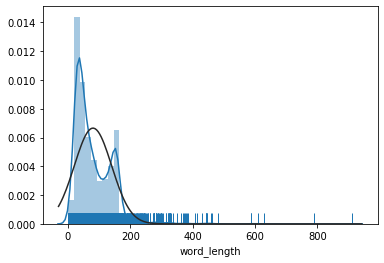

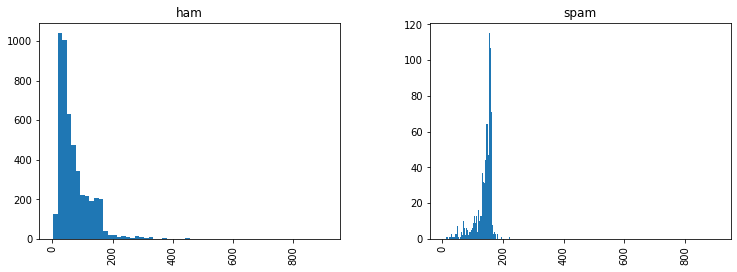

In [5]:
sms['word_length'] = sms['sms'].apply(len)

from scipy.stats import norm
ax = sns.distplot(sms['word_length'], fit=norm, kde=True,rug=True, hist=True)

sms.hist(column='word_length',by='tag',bins=60,figsize=(12,4));
plt.xlim(-40,950);

#### Wordcloud showing top spam and non-spam words

In [6]:
data_ham = sms[sms['tag'] == 'ham']
data_spam = sms[sms['tag'] == 'spam']

In [7]:
import wordcloud

def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['sms'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

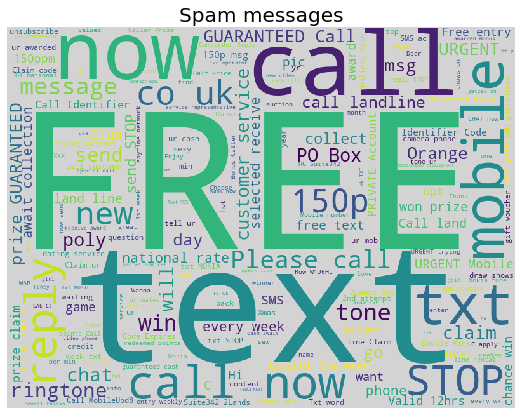

In [8]:
show_wordcloud(data_spam, "Spam messages")

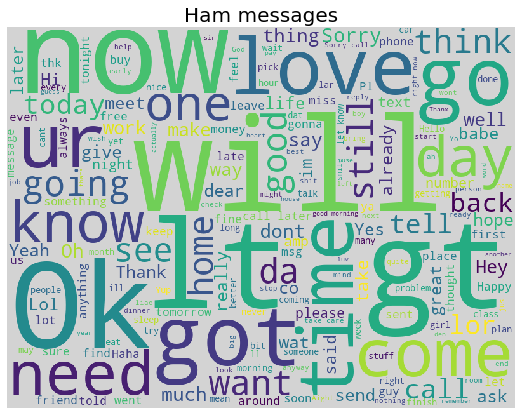

In [9]:
show_wordcloud(data_ham, "Ham messages")

#### Text Data Preprocessing

In [10]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import spacy
import re

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = sms.sms.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

C:\Users\anirban.c\AppData\Local\Continuum\anaconda3\envs\anirban\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']]


In [11]:
import warnings
warnings.filterwarnings('ignore')

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
from nltk.corpus import stopwords
from collections import Counter
stop_words = stopwords.words('english')
import spacy
nlp = spacy.load('en_core_web_sm')

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [13]:
data_ready = process_words(data_words)  # processed Text Data!

In [14]:
list_of_words = []
for sublist in data_ready:
    for item in sublist:
        list_of_words.append(item)

c_ham  = Counter(list_of_words)
topsy=50
df_words_top50 = pd.DataFrame(c_ham.most_common(topsy), columns=['word', 'count'])

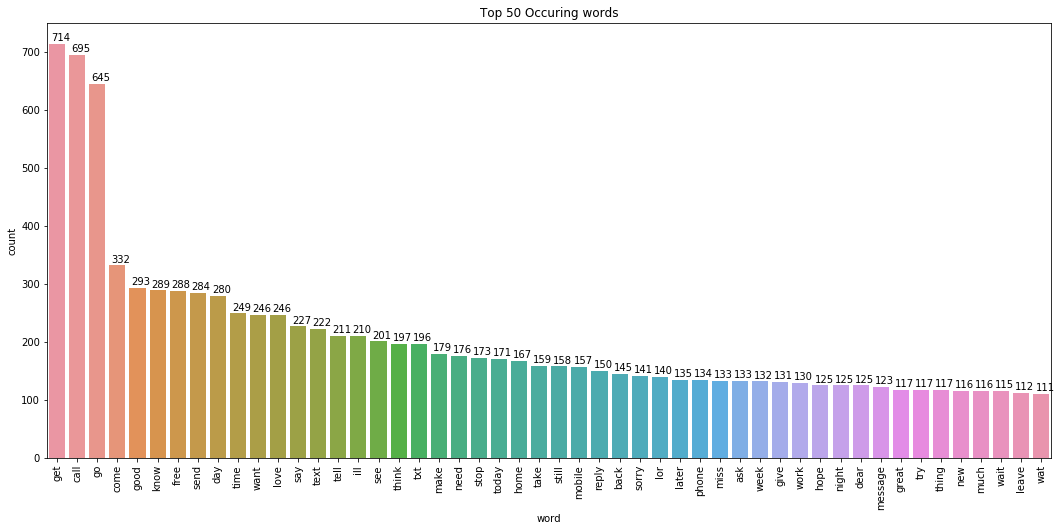

In [15]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(x='word', y='count', 
            data=df_words_top50, ax=ax)
plt.title("Top {} Occuring words".format(topsy))
plt.xticks(rotation='vertical');


for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=160,
                                           update_every=1,
                                           chunksize=20,
                                           passes=20,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.046*"good" + 0.038*"give" + 0.031*"later" + 0.030*"need" + 0.029*"say" + 0.027*"ask" + 0.024*"keep" + 0.022*"well" + 0.020*"buy" + 0.018*"hope"'), (1, '0.162*"get" + 0.033*"wat" + 0.033*"try" + 0.031*"great" + 0.026*"thing" + 0.023*"way" + 0.021*"cos" + 0.015*"dat" + 0.015*"feel" + 0.015*"miss"'), (2, '0.134*"go" + 0.051*"want" + 0.036*"home" + 0.031*"today" + 0.026*"night" + 0.022*"tonight" + 0.021*"soon" + 0.019*"stuff" + 0.018*"also" + 0.015*"msg"'), (3, '0.080*"day" + 0.051*"make" + 0.032*"smile" + 0.031*"reply" + 0.027*"friend" + 0.027*"cash" + 0.026*"name" + 0.022*"start" + 0.018*"pound" + 0.011*"someone"'), (4, '0.059*"time" + 0.056*"come" + 0.052*"think" + 0.033*"take" + 0.025*"dear" + 0.022*"wish" + 0.019*"help" + 0.019*"thank" + 0.018*"sleep" + 0.014*"late"'), (5, '0.060*"send" + 0.042*"back" + 0.041*"still" + 0.033*"much" + 0.027*"cool" + 0.023*"pick" + 0.021*"problem" + 0.018*"nite" + 0.018*"minute" + 0.016*"watch"'), (6, '0.144*"call" + 0.047*"text" + 0.030*"min" +

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6712,"get, wat, try, great, thing, way, cos, dat, fe...","[go, jurong, point, crazy, available, bugis, g..."
1,1,2.0,0.4017,"go, want, home, today, night, tonight, soon, s...","[joke, wif, oni]"
2,2,6.0,0.8371,"call, text, min, txt, number, claim, prize, co...","[free, entry, wkly, comp, win, cup, final, tkt..."
3,3,0.0,0.8714,"good, give, later, need, say, ask, keep, well,...","[dun, say, early, hor, already, say]"
4,4,4.0,0.5857,"time, come, think, take, dear, wish, help, tha...","[think, go, usf, life, around, though]"
5,5,5.0,0.5288,"send, back, still, much, cool, pick, problem, ...","[darle, week, word, back, fun, still, tb, xxx,..."
6,6,9.0,0.6787,"free, mobile, week, phone, www, even, urgent, ...","[even, brother, speak, treat, aid, patent]"
7,7,3.0,0.7528,"day, make, smile, reply, friend, cash, name, s...","[request, melle, melle, oru, minnaminunginte, ..."
8,8,6.0,0.9400,"call, text, min, txt, number, claim, prize, co...","[winner, value, network, customer, select, rec..."
9,9,9.0,0.7928,"free, mobile, week, phone, www, even, urgent, ...","[mobile, month, entitle, update, latest_colour..."


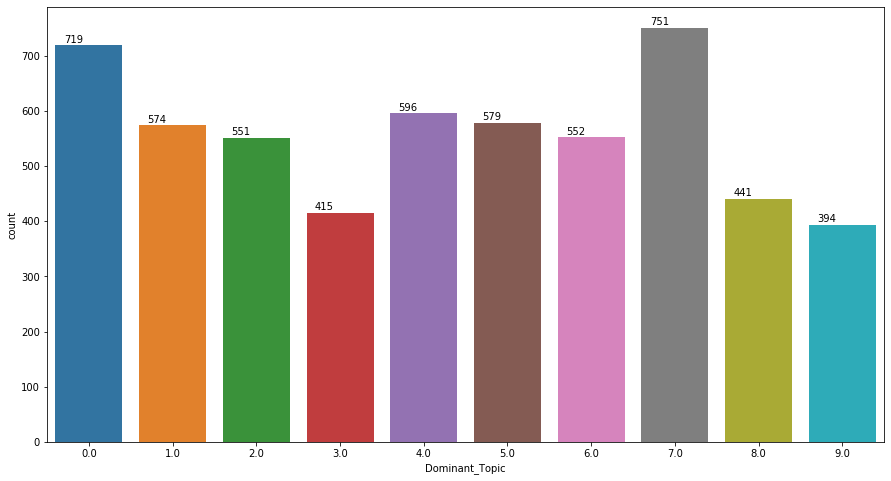

In [22]:
plt.figure(figsize=(15,8))
ax=sns.countplot(x="Dominant_Topic", data=df_dominant_topic)

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))



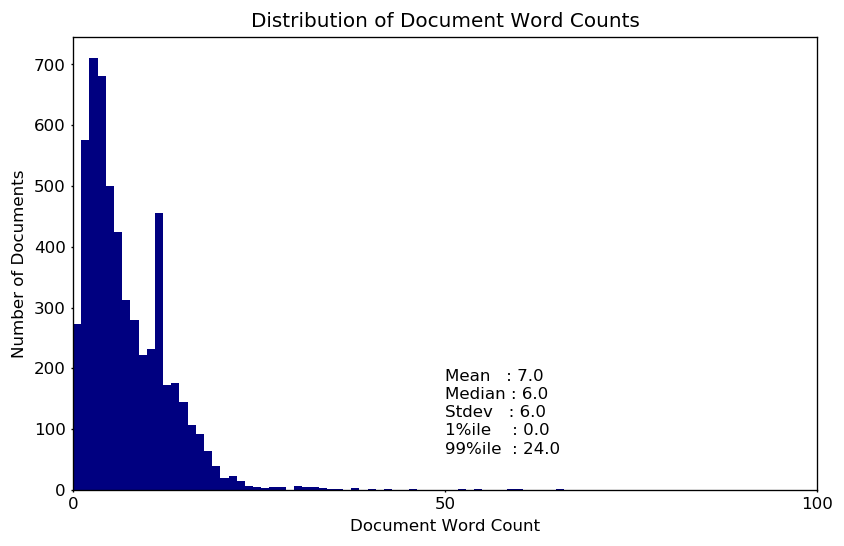

In [23]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,5), dpi=120)
plt.hist(doc_lens, bins = 60, color='navy')

plt.text(50, 180, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(50, 150, "Median : " + str(round(np.median(doc_lens))))
plt.text(50, 120, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(50, 90, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(50, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 90), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=1)
plt.xticks(np.linspace(0,100,3))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

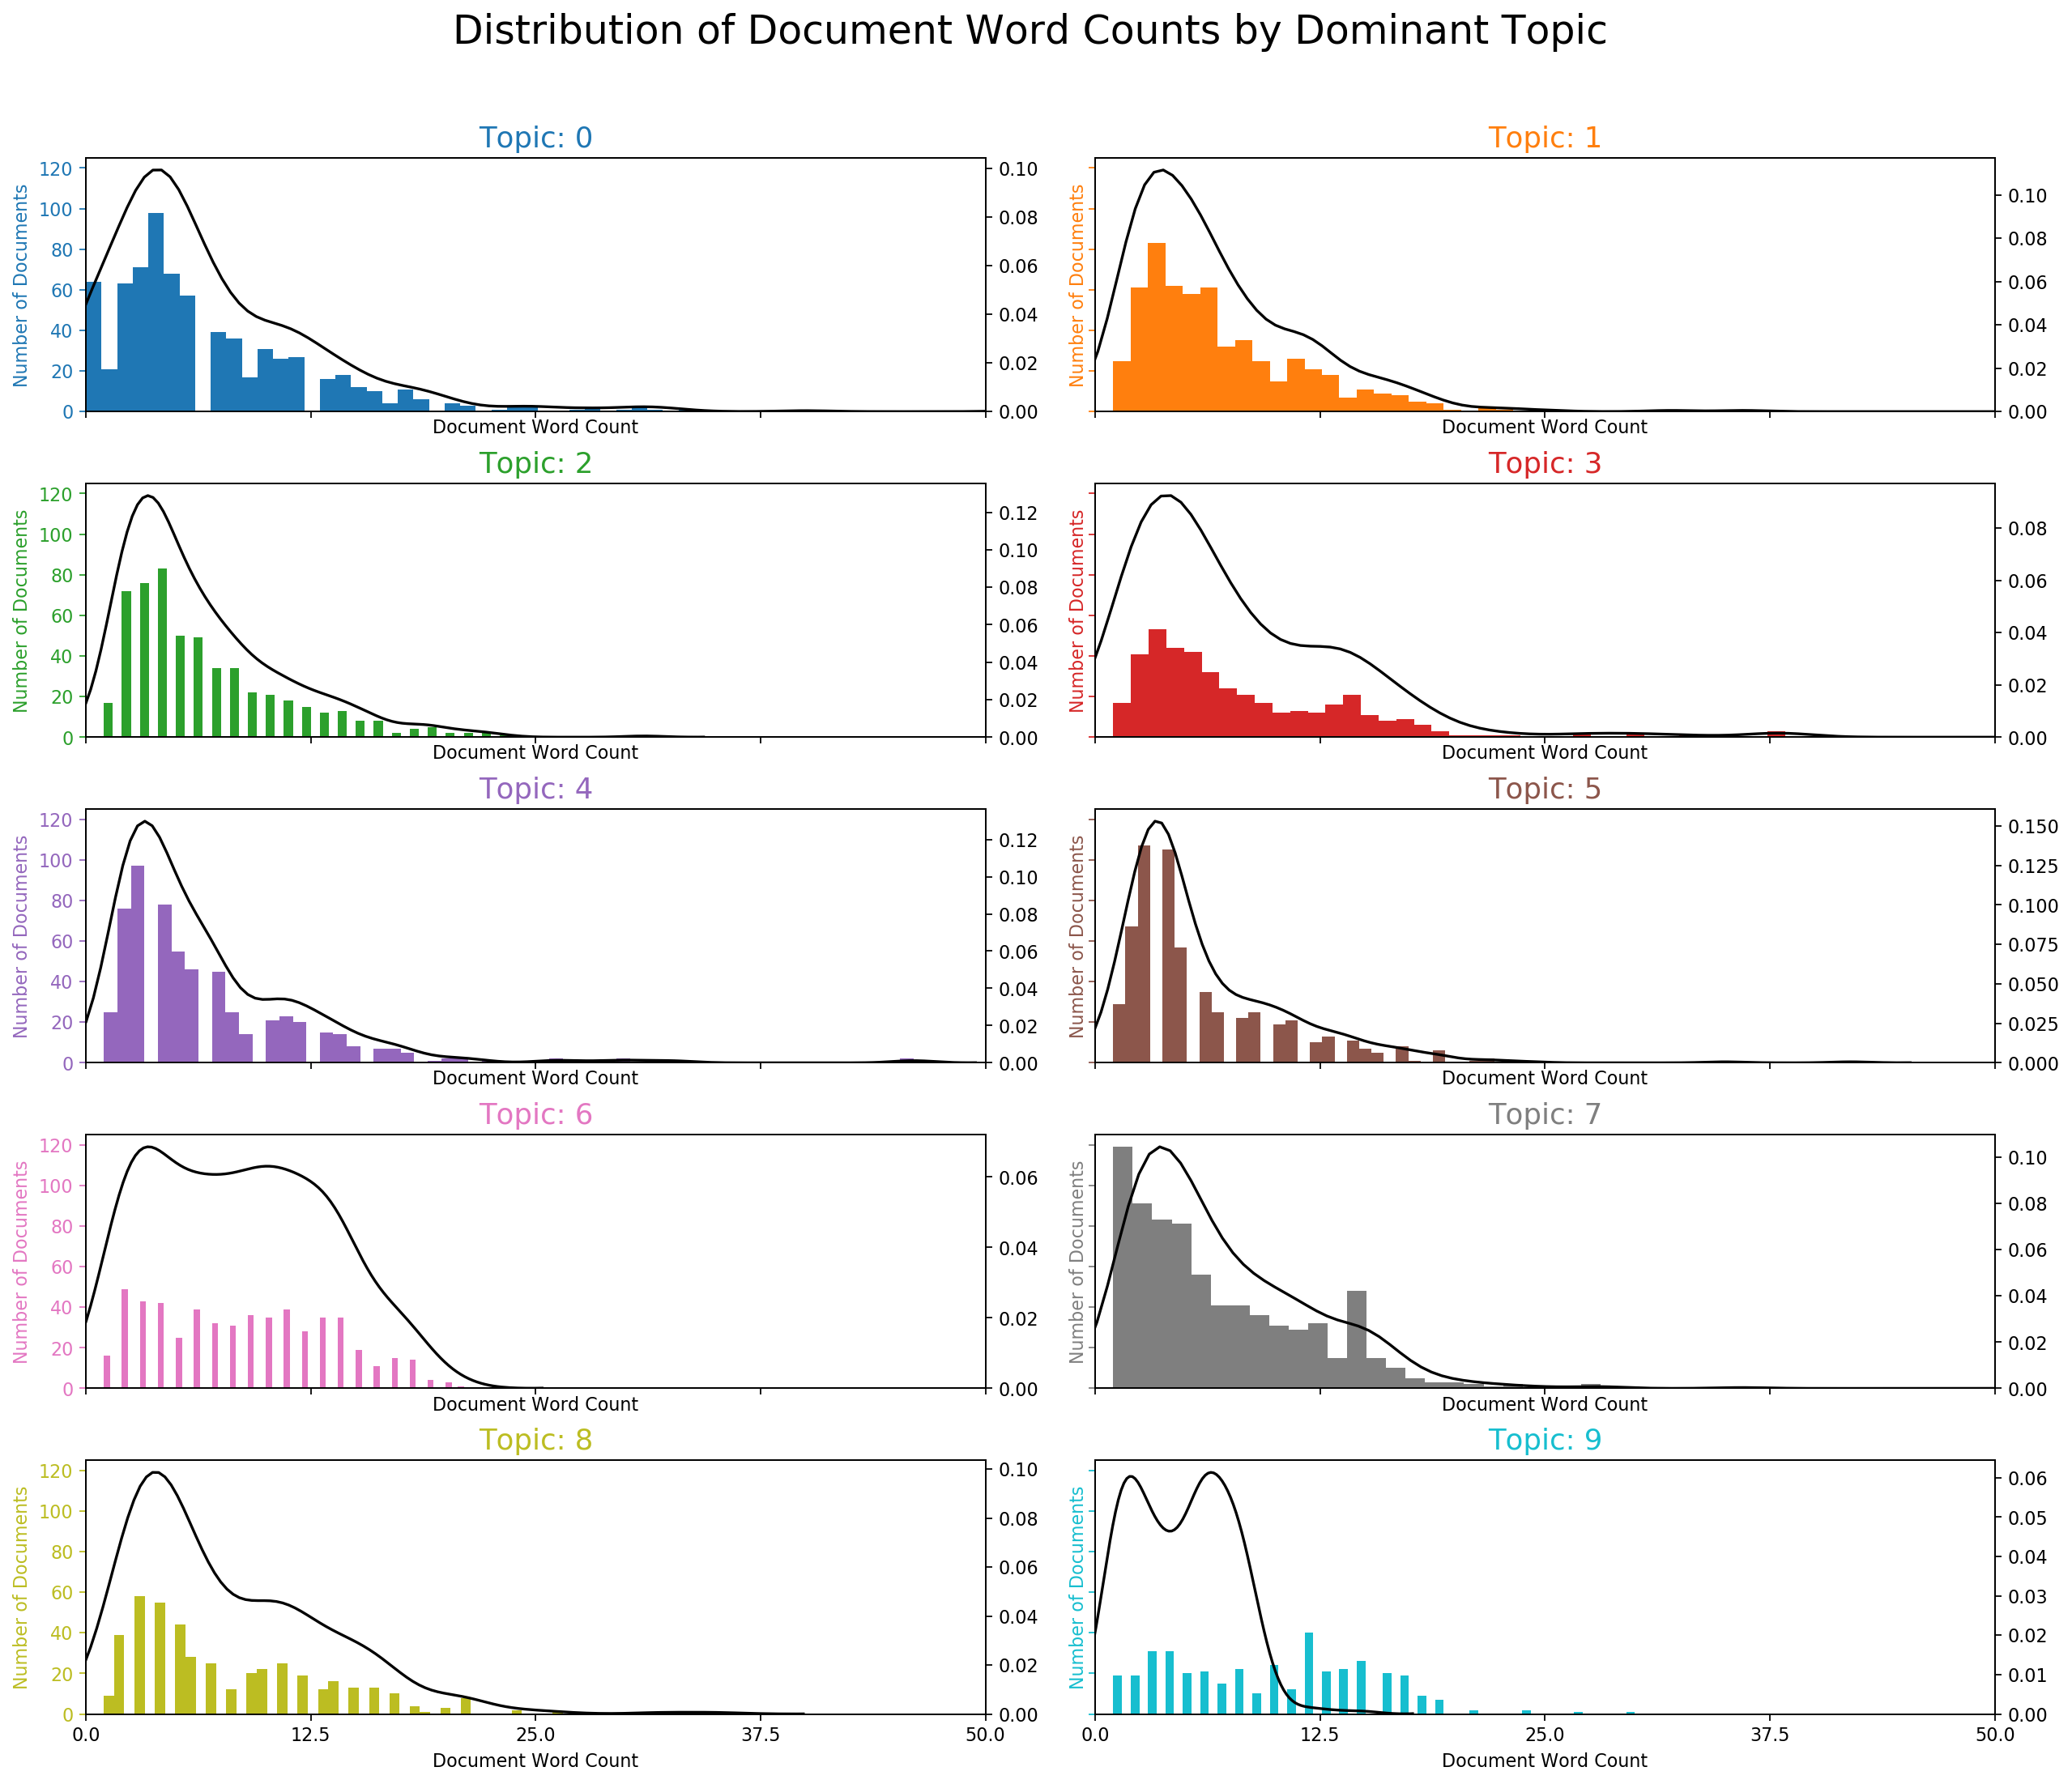

In [24]:
# import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 60, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 50), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

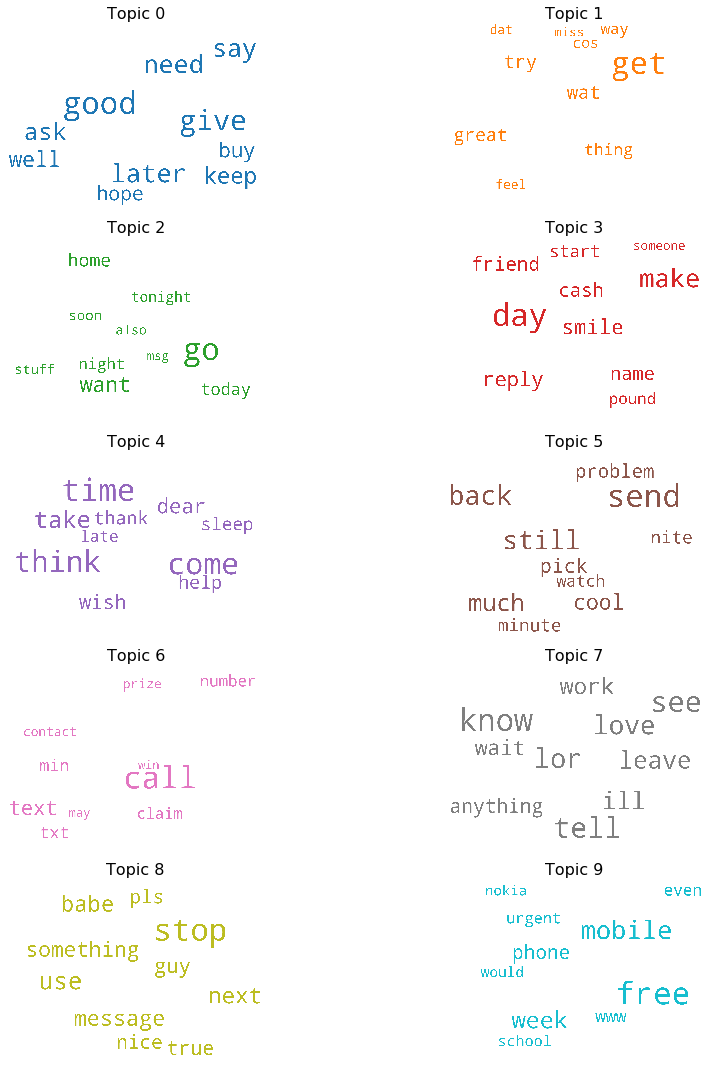

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab0',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

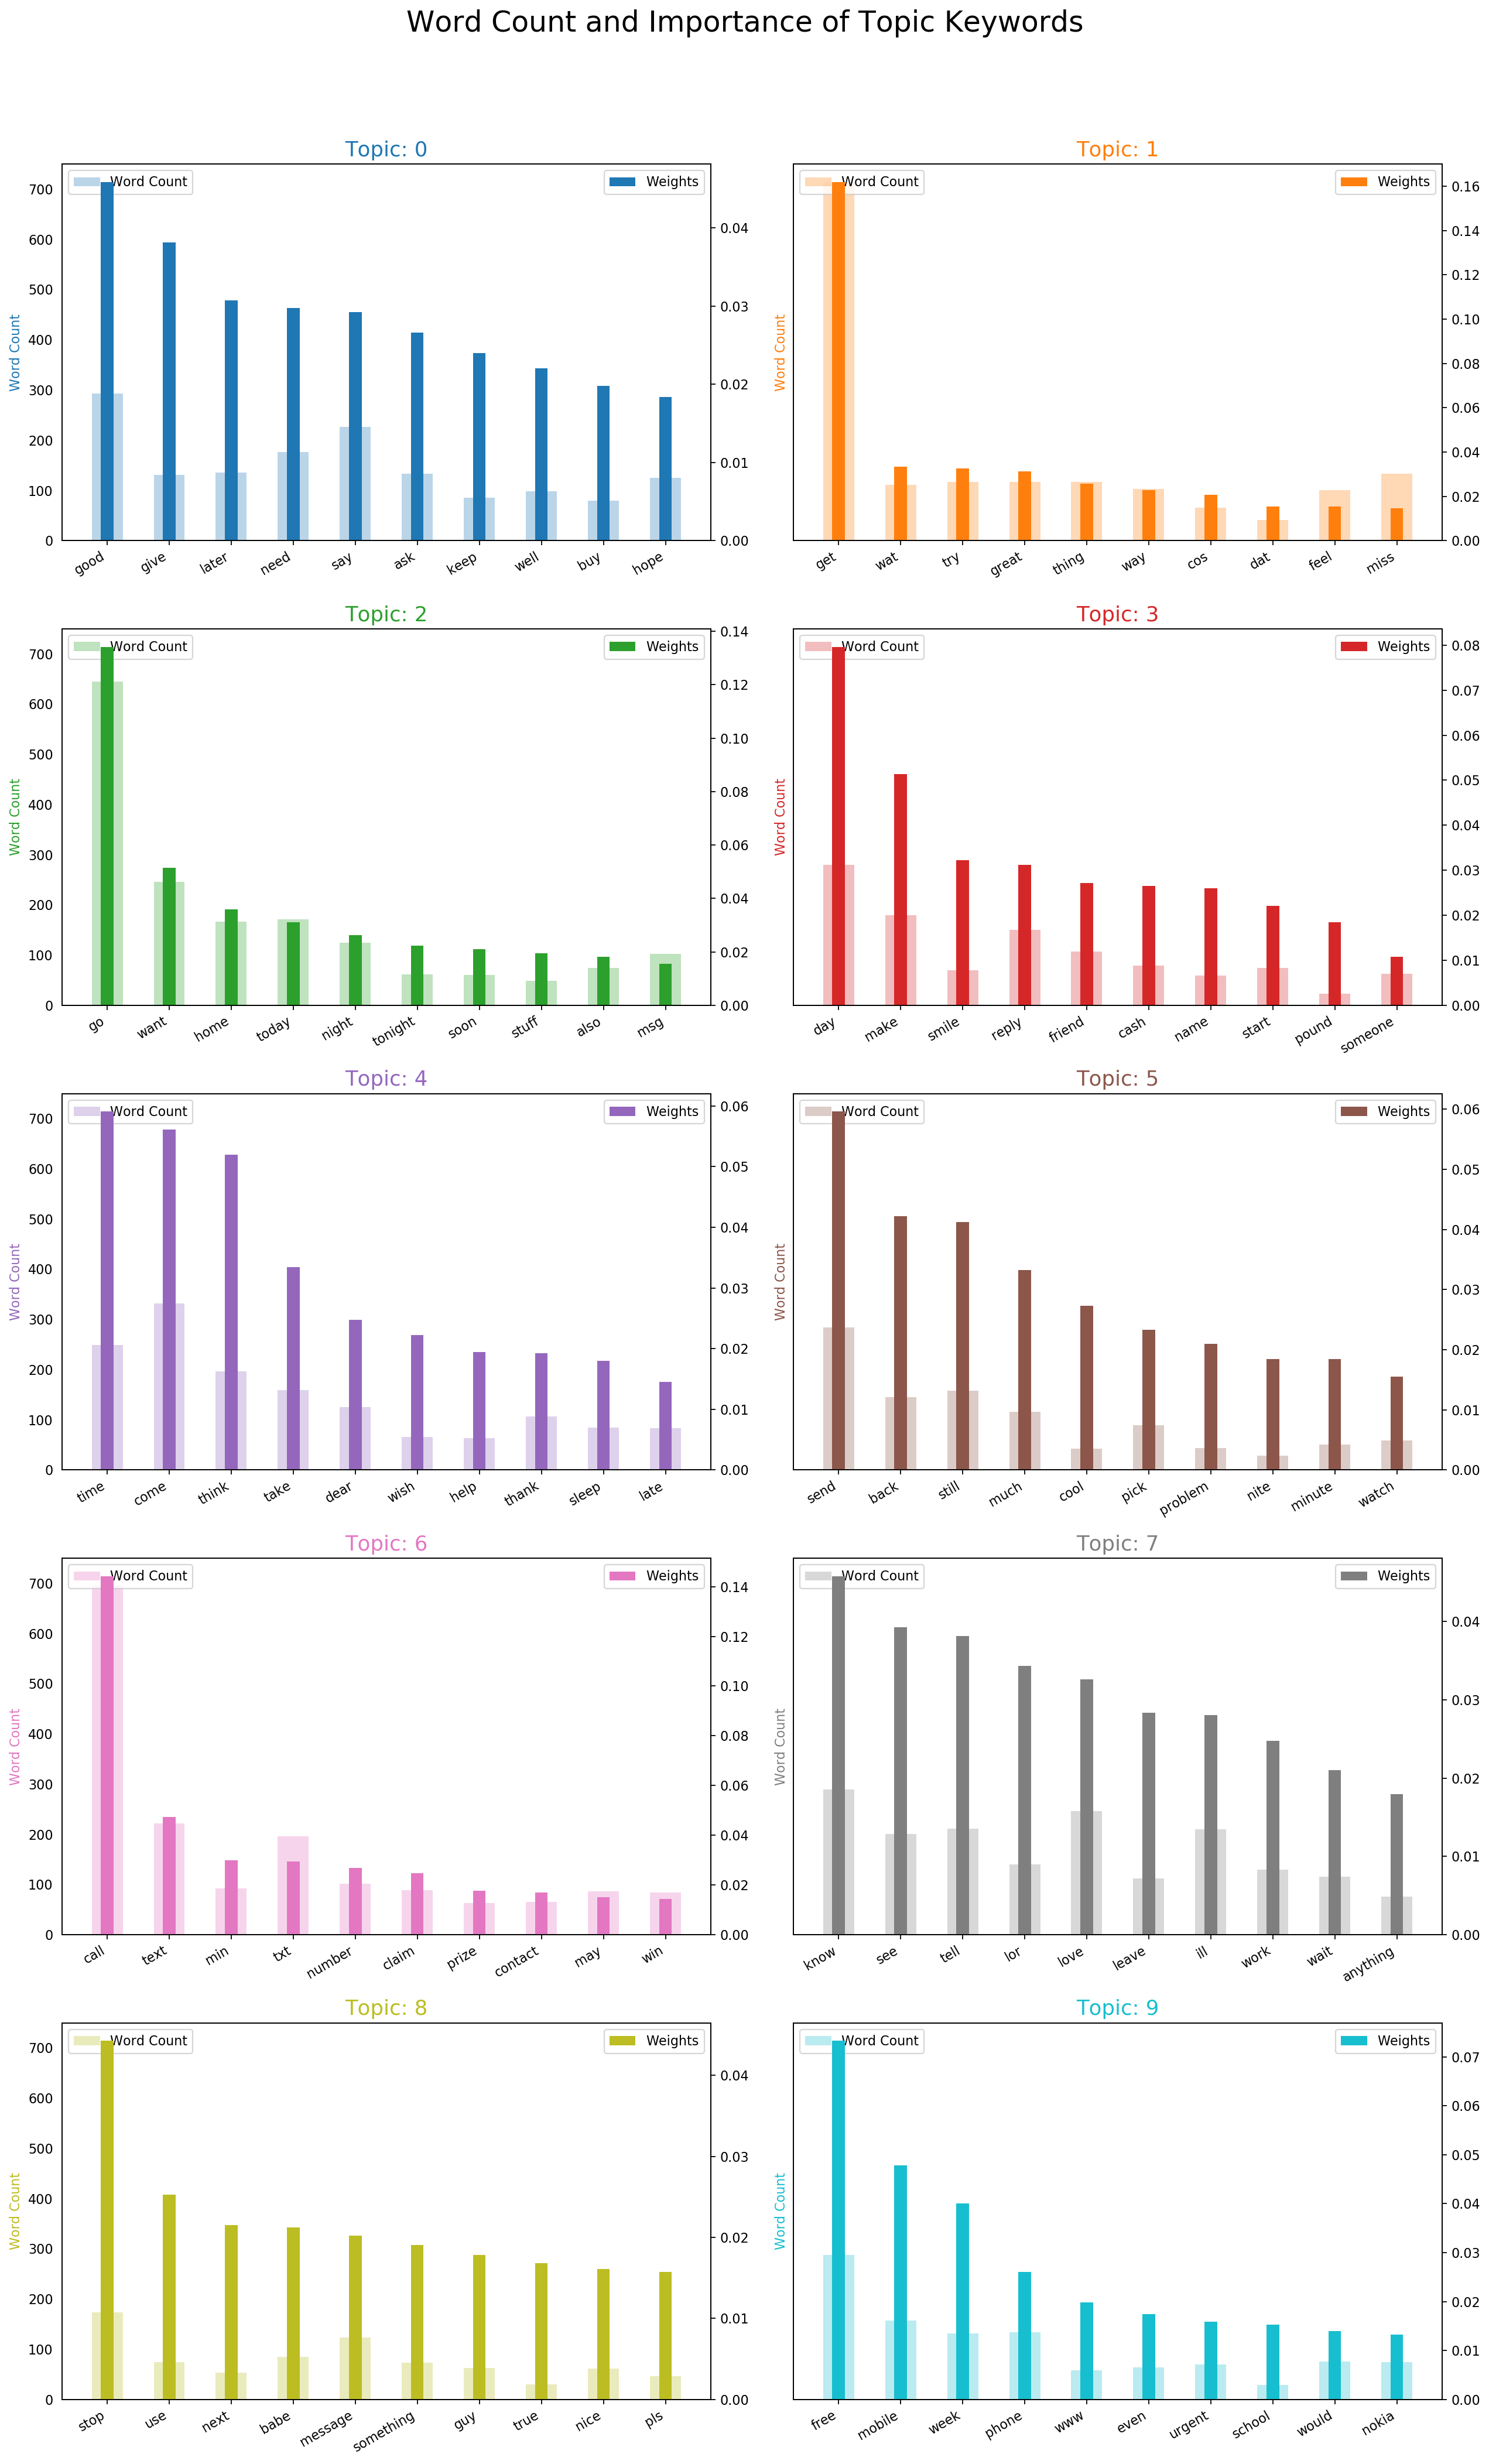

In [26]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,25), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


In [27]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

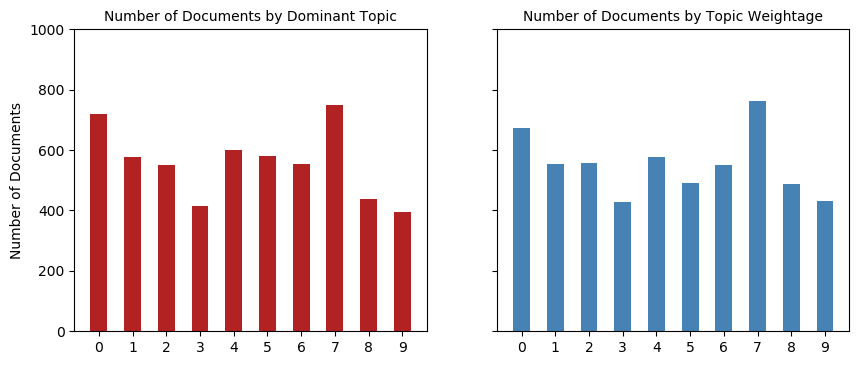

In [28]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()


In [39]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
from bokeh.models import HoverTool

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', learning_rate=100)
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10


mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700, tools=['pan','wheel_zoom'])

plot.circle(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], legend="")
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3782 samples in 0.002s...
[t-SNE] Computed neighbors for 3782 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3782
[t-SNE] Computed conditional probabilities for sample 2000 / 3782
[t-SNE] Computed conditional probabilities for sample 3000 / 3782
[t-SNE] Computed conditional probabilities for sample 3782 / 3782
[t-SNE] Mean sigma: 0.000038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.833282
[t-SNE] KL divergence after 1000 iterations: 0.759040


Loading BokehJS ...

In [30]:
topic_num.shape

(3782,)

In [31]:
np.unique(topic_num)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [32]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 5572);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [33]:
lda_model.show_topic(2,topn = 2)

[('go', 0.13419567), ('want', 0.05143379)]

In [34]:
lda_topics=get_lda_topics(lda_model, 10)
lda_topics.head(20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,good,get,go,day,time,send,call,know,stop,free
1,give,wat,want,make,come,back,text,see,use,mobile
2,later,try,home,smile,think,still,min,tell,next,week
3,need,great,today,reply,take,much,txt,lor,babe,phone
4,say,thing,night,friend,dear,cool,number,love,message,www
5,ask,way,tonight,cash,wish,pick,claim,leave,something,even
6,keep,cos,soon,name,help,problem,prize,ill,guy,urgent
7,well,dat,stuff,start,thank,nite,contact,work,true,school
8,buy,feel,also,pound,sleep,minute,may,wait,nice,would
9,hope,miss,msg,someone,late,watch,win,anything,pls,nokia


In [35]:
sms_updated=pd.concat([sms,df_dominant_topic,lda_topics],axis=1)
sms_updated=sms_updated.drop(['Text'], axis=1)
sms_updated.head()

,tag,sms,word_length,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,ham,"Go until jurong point, crazy.. Available only ...",111,0,1.0,0.6712,"get, wat, try, great, thing, way, cos, dat, fe...",good,get,go,day,time,send,call,know,stop,free
1,ham,Ok lar... Joking wif u oni...,29,1,2.0,0.4017,"go, want, home, today, night, tonight, soon, s...",give,wat,want,make,come,back,text,see,use,mobile
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,6.0,0.8371,"call, text, min, txt, number, claim, prize, co...",later,try,home,smile,think,still,min,tell,next,week
3,ham,U dun say so early hor... U c already then say...,49,3,0.0,0.8714,"good, give, later, need, say, ask, keep, well,...",need,great,today,reply,take,much,txt,lor,babe,phone
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,4,4.0,0.5857,"time, come, think, take, dear, wish, help, tha...",say,thing,night,friend,dear,cool,number,love,message,www


In [36]:
sms_updated.groupby(['Dominant_Topic'])['Topic_Perc_Contrib'].mean()


Dominant_Topic
0.0    0.410151
1.0    0.406565
2.0    0.428056
3.0    0.424695
4.0    0.433020
5.0    0.428577
6.0    0.505645
7.0    0.449378
8.0    0.453126
9.0    0.450744
Name: Topic_Perc_Contrib, dtype: float64

In [37]:
sms_updated.groupby(['Dominant_Topic'])['word_length'].mean()

Dominant_Topic
0.0     74.296245
1.0     73.144599
2.0     67.119782
3.0     88.462651
4.0     72.171141
5.0     65.367876
6.0    112.061594
7.0     78.949401
8.0     81.650794
9.0    105.005076
Name: word_length, dtype: float64

In [35]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word,sort_topics=False)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029918 -0.253975       1        1  12.310497
1     -0.025134  0.067310       2        1   9.752141
2     -0.056229  0.187796       3        1   9.343440
3      0.025703  0.003537       4        1   8.242230
4     -0.010936  0.120931       5        1   9.762967
5      0.016690  0.077698       6        1   8.000487
6      0.227606 -0.123929       7        1  11.250314
7     -0.304673 -0.109014       8        1  13.074556
8      0.037821  0.048605       9        1   9.125637
9      0.119071 -0.018958      10        1   9.137724, topic_info=     Category        Freq     Term       Total  loglift  logprob
6     Default  638.000000      get  638.000000  30.0000  30.0000
71    Default  655.000000     call  655.000000  29.0000  29.0000
7     Default  507.000000       go  507.000000  28.0000  28.0000
107   Default  265.000000      day  265.000000  27.0000  27.0000
20    Default  271.000000     free  271.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
1462  Topic10   23.263374   remove   24.072653   2.3586  -5.0662
54    Topic10   23.149649  brother   23.958292   2.3584  -5.0711
2098  Topic10   23.061367    comuk   23.876268   2.3580  -5.0749
527   Topic10   22.291462     busy   23.100327   2.3571  -5.1089
680   Topic10   21.743311    dream   22.551975   2.3562  -5.1338

[341 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1972      9  0.947001      act
1335      4  0.939381       ad
516       2  0.967016    aight
2986      5  0.963318    alone
32        1  0.990150  already
...     ...       ...      ...
523      10  0.978411    would
120      10  0.983949      www
52        6  0.960536      xxx
352       1  0.975400     year
500       6  0.964285      yet

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])